<a href="https://colab.research.google.com/github/anyarlene/AdvancedProject2/blob/main/advancedproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Loading the Drive helper and mount
from google.colab import drive
#HERE Will prompt for authorisation
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# How do PV infeed change phasor angle information?

#### Libraries

In [2]:
#Importing packages that may be needed:

import pandas as pd # data processing
import numpy as np # linear algebra
import math
import dask.dataframe as dd
import os
from tqdm import tqdm

import statsmodels.api as sm
#import statsmodels.api as sm

import matplotlib.pyplot as plt # this is used for the plot the graph
import plotly.express as px # this is used for the plot the graph
import seaborn as sns # used for plot interactive graph.
from matplotlib import pylab

from sklearn.metrics import r2_score

import sys 
from scipy.stats import randint
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Energy solar data

In [3]:
path1 = '/content/drive/My Drive/5/solar-15m_2019-09-01_2020-09-30.csv'
PV_df = pd.read_csv(path1)

In [4]:
PV_df.head()

time  ...  Solarenergie_Prognose_TransnetBW
0  2019-09-01 00:00:00  ...                               0.0
1  2019-09-01 00:15:00  ...                               0.0
2  2019-09-01 00:30:00  ...                               0.0
3  2019-09-01 00:45:00  ...                               0.0
4  2019-09-01 01:00:00  ...                               0.0

[5 rows x 9 columns]

In [5]:
PV_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38008 entries, 0 to 38007
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   time                                  38008 non-null  object 
 1   Solarenergie_Hochrechnung_50Hertz     38008 non-null  int64  
 2   Solarenergie_Hochrechnung_Amprion     38008 non-null  float64
 3   Solarenergie_Hochrechnung_TenneT_TSO  38008 non-null  float64
 4   Solarenergie_Hochrechnung_TransnetBW  38008 non-null  float64
 5   Solarenergie_Prognose_50Hertz         38008 non-null  float64
 6   Solarenergie_Prognose_Amprion         38008 non-null  int64  
 7   Solarenergie_Prognose_TenneT_TSO      38008 non-null  float64
 8   Solarenergie_Prognose_TransnetBW      38008 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 2.6+ MB


In [6]:
PV_df.shape

(38008, 9)

In [7]:
display(PV_df.head())
display(PV_df.tail())

time  ...  Solarenergie_Prognose_TransnetBW
0  2019-09-01 00:00:00  ...                               0.0
1  2019-09-01 00:15:00  ...                               0.0
2  2019-09-01 00:30:00  ...                               0.0
3  2019-09-01 00:45:00  ...                               0.0
4  2019-09-01 01:00:00  ...                               0.0

[5 rows x 9 columns]

time  ...  Solarenergie_Prognose_TransnetBW
38003  2020-09-30 22:45:00  ...                               0.0
38004  2020-09-30 23:00:00  ...                               0.0
38005  2020-09-30 23:15:00  ...                               0.0
38006  2020-09-30 23:30:00  ...                               0.0
38007  2020-09-30 23:45:00  ...                               0.0

[5 rows x 9 columns]

In [8]:
# Number of missing values in each column of dataframe
missing_val = (PV_df.isna().sum())
print("missing values in each column: \n",missing_val)

missing values in each column: 
 time                                    0
Solarenergie_Hochrechnung_50Hertz       0
Solarenergie_Hochrechnung_Amprion       0
Solarenergie_Hochrechnung_TenneT_TSO    0
Solarenergie_Hochrechnung_TransnetBW    0
Solarenergie_Prognose_50Hertz           0
Solarenergie_Prognose_Amprion           0
Solarenergie_Prognose_TenneT_TSO        0
Solarenergie_Prognose_TransnetBW        0
dtype: int64


In [9]:
PV_df['time'] = pd.to_datetime(PV_df['time'], format='%Y-%m-%d %H:%M')

PV_df['Date'] = [d.date() for d in PV_df['time']]
PV_df['Time'] = [d.time() for d in PV_df['time']]

PV_df = PV_df.set_index(['time'])
PV_df.head()

Solarenergie_Hochrechnung_50Hertz  ...      Time
time                                                    ...          
2019-09-01 00:00:00                                  0  ...  00:00:00
2019-09-01 00:15:00                                  0  ...  00:15:00
2019-09-01 00:30:00                                  0  ...  00:30:00
2019-09-01 00:45:00                                  0  ...  00:45:00
2019-09-01 01:00:00                                  0  ...  01:00:00

[5 rows x 10 columns]

In [10]:
# start and end dates of the time series
print ("solar energy dataset: start_date = {}, end_date = {} \n".format(PV_df.index.min(), PV_df.index.max()))

solar energy dataset: start_date = 2019-09-01 00:00:00, end_date = 2020-09-30 23:45:00 



CPU times: user 1.23 s, sys: 160 ms, total: 1.39 s
Wall time: 1.29 s


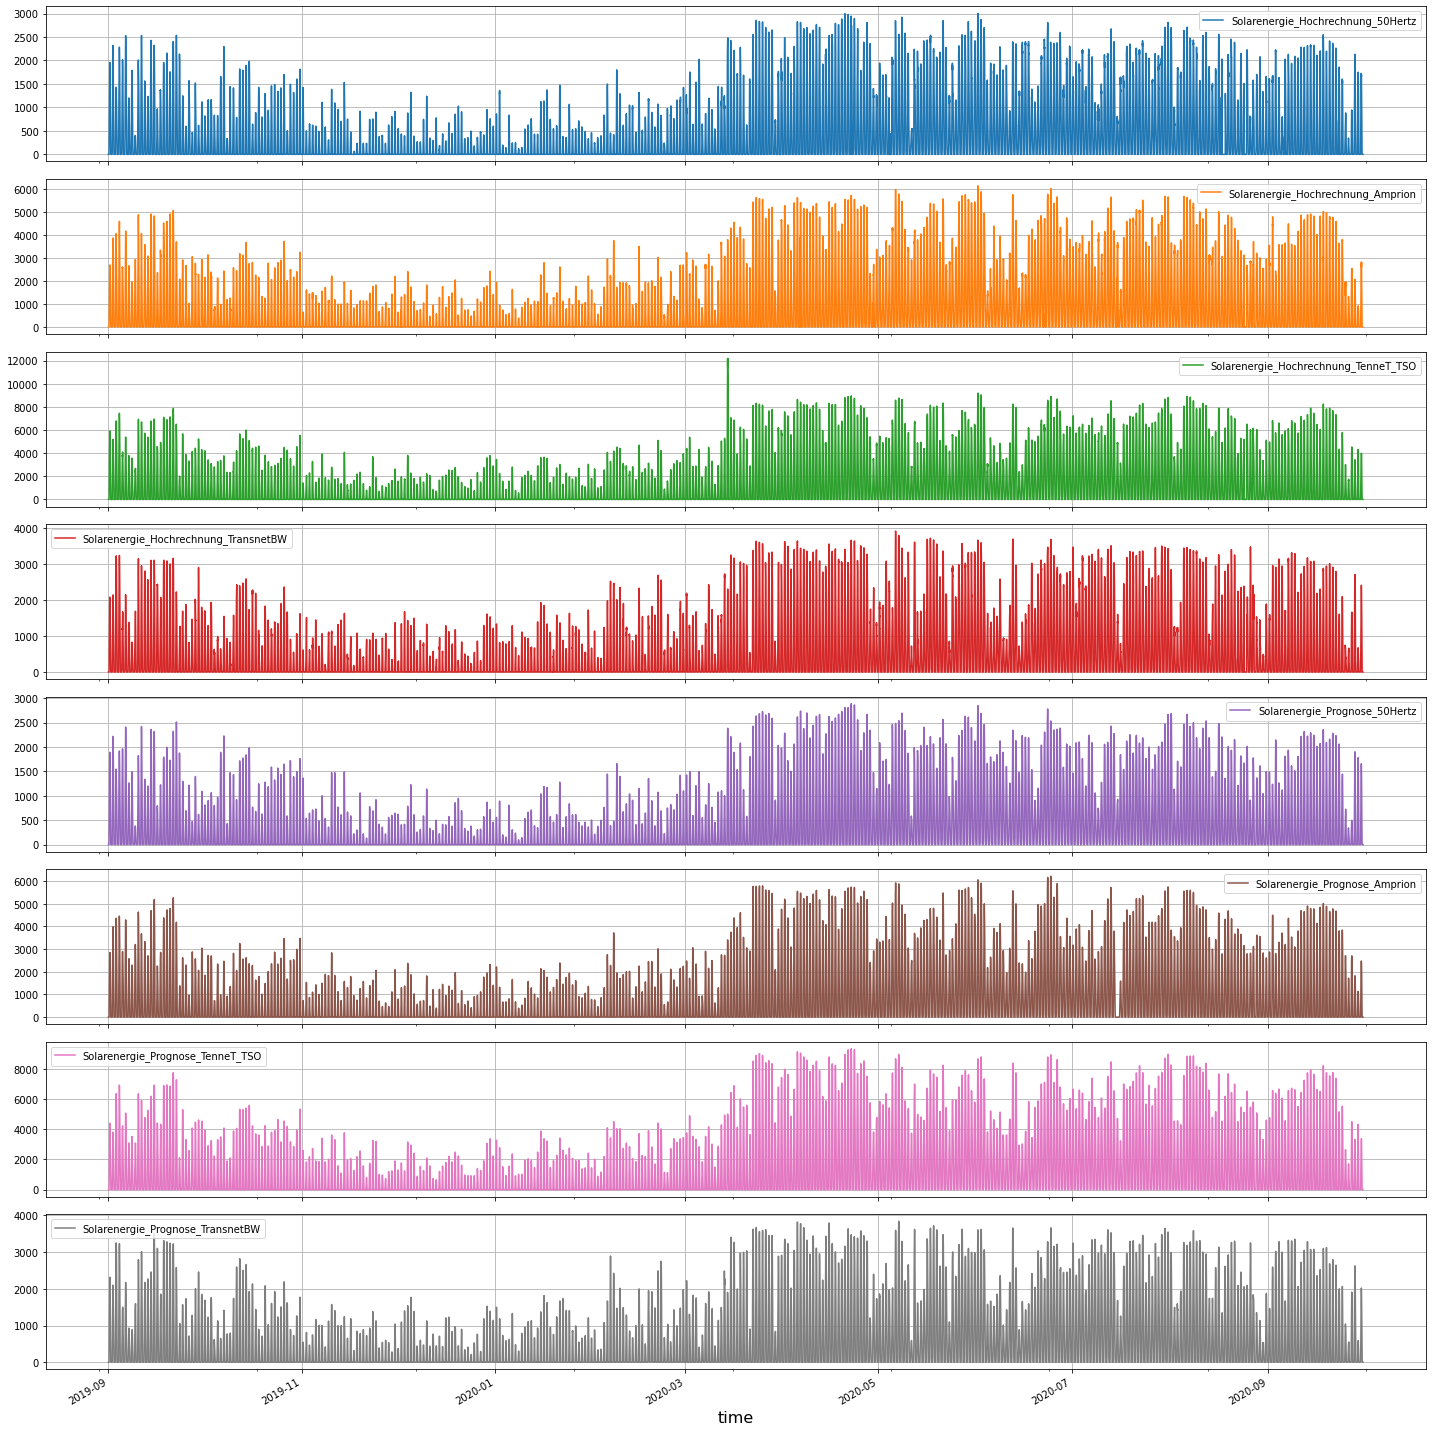

In [11]:
%%time
PV_df.plot(grid =True, subplots=True, figsize = (20, 20))
plt.xlabel('time', fontsize=16)
plt.legend(loc="upper left")
plt.tight_layout()

In [12]:
PV_df.describe()

Solarenergie_Hochrechnung_50Hertz  ...  Solarenergie_Prognose_TransnetBW
count                       38008.000000  ...                      38008.000000
mean                          462.177436  ...                        611.117293
std                           713.049598  ...                        939.964380
min                             0.000000  ...                          0.000000
25%                             0.000000  ...                          0.000000
50%                             5.000000  ...                          5.011000
75%                           727.000000  ...                        964.000000
max                          3002.000000  ...                       3839.000000

[8 rows x 8 columns]

In [13]:
PV_df = PV_df.reset_index(['time'])
#aggregate_pv_df = PV_df.copy()[['Date', 'Time']]
aggregate_pv_df = PV_df.copy()[['time']]
aggregate_pv_df['Hochrechnung_Total'] =  PV_df[['Solarenergie_Hochrechnung_50Hertz','Solarenergie_Hochrechnung_Amprion', 'Solarenergie_Hochrechnung_TenneT_TSO', 'Solarenergie_Hochrechnung_TransnetBW']].sum(axis=1)
aggregate_pv_df['Prognose_Total'] =  PV_df[['Solarenergie_Prognose_50Hertz','Solarenergie_Prognose_Amprion', 'Solarenergie_Prognose_TenneT_TSO', 'Solarenergie_Prognose_TransnetBW']].sum(axis=1)

aggregate_pv_df.head()

time  Hochrechnung_Total  Prognose_Total
0 2019-09-01 00:00:00               19.29             0.0
1 2019-09-01 00:15:00               19.26             0.0
2 2019-09-01 00:30:00               19.26             0.0
3 2019-09-01 00:45:00               19.24             0.0
4 2019-09-01 01:00:00               19.25             0.0

In [14]:
aggregate_pv_df = aggregate_pv_df.set_index(['time'])
aggregate_pv_df.head()

Hochrechnung_Total  Prognose_Total
time                                                   
2019-09-01 00:00:00               19.29             0.0
2019-09-01 00:15:00               19.26             0.0
2019-09-01 00:30:00               19.26             0.0
2019-09-01 00:45:00               19.24             0.0
2019-09-01 01:00:00               19.25             0.0

In [15]:
# start and end dates of the time series
print ("PV dataset: start_date = {}, end_date = {} \n".format(aggregate_pv_df.index.min(), aggregate_pv_df.index.max()))

PV dataset: start_date = 2019-09-01 00:00:00, end_date = 2020-09-30 23:45:00 



In [16]:
aggregate_pv_df.shape

(38008, 2)

In [17]:
aggregate_pv_df.describe()

Hochrechnung_Total  Prognose_Total
count        38008.000000    38008.000000
mean          3445.664834     3465.245366
std           5215.502227     5226.591542
min              0.000000        0.000000
25%              0.000000        0.000000
50%             64.983000      102.846000
75%           5568.019250     5646.007000
max          21944.654000    21410.620000

CPU times: user 184 ms, sys: 22.7 ms, total: 207 ms
Wall time: 208 ms


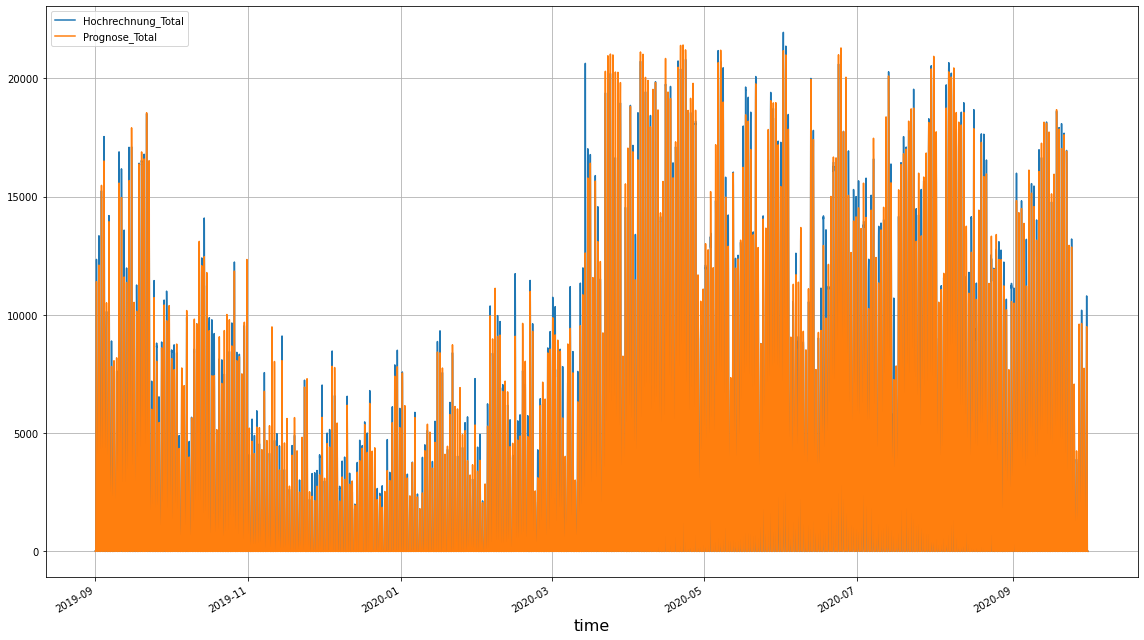

In [18]:
%%time
aggregate_pv_df['Hochrechnung_Total'].plot(grid = True, figsize = (16, 9))
aggregate_pv_df['Prognose_Total'].plot(grid = True, figsize = (16, 9))
plt.xlabel('time', fontsize=16)
plt.legend(loc="upper left")
plt.tight_layout()

### Heatmap visualization

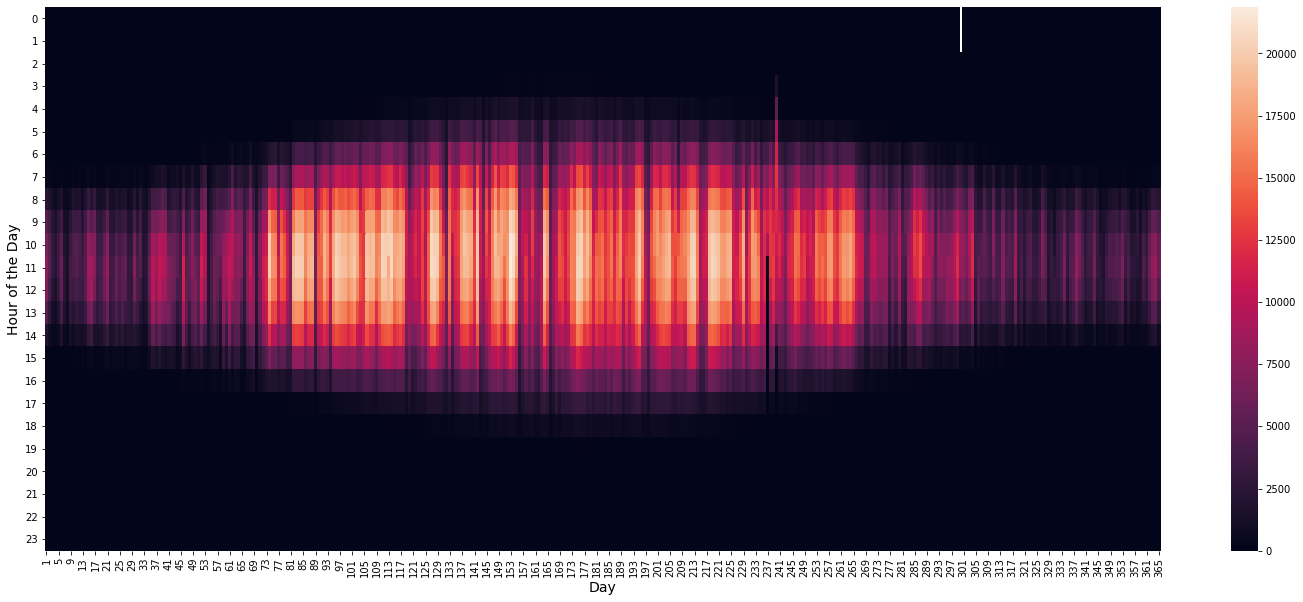

In [19]:
pv_heatmap_df = aggregate_pv_df.copy()
pv_heatmap_df = pv_heatmap_df.reset_index()

time_series_2020 = (pv_heatmap_df['time'] >= ('2019-09-01')) & (pv_heatmap_df['time'] <= ('2020-09-30'))
from_jan_2020 = pv_heatmap_df.loc[time_series_2020]
from_jan_2020 = from_jan_2020.set_index(['time'])

#Create variables for Day and hour
from_jan_2020['day'] = [i.dayofyear for i in from_jan_2020.index]
from_jan_2020['hour'] = [i.hour for i in from_jan_2020.index]

# group by month and year, get the average
from_jan_2020 = from_jan_2020.groupby(['day', 'hour']).mean()

from_jan_2020= from_jan_2020['Hochrechnung_Total'].unstack(level=0)

fig, ax = plt.subplots(figsize=(25, 10))
#cmap = "Reds"
#cmap = "RdPu"
#cmap = "YlOrRd"
#cmap = "autumn"
#cmap = "hot"
#cmap="OrRd"
#cmap = "Oranges"
sns.heatmap(from_jan_2020, vmin=0)
plt.xlabel("Day", fontsize=14)
plt.ylabel("Hour of the Day", fontsize=14)

# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0)
#plt.xticks(rotation=0)
plt.show()

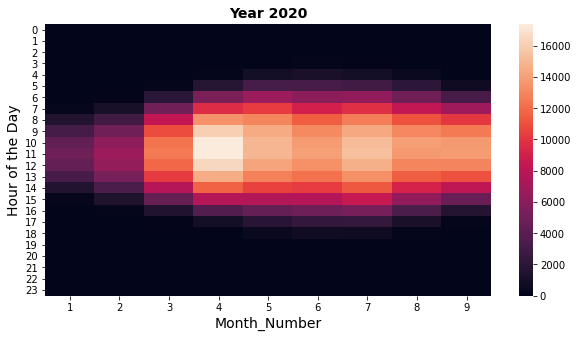

In [20]:
pv_heatmap_df2 = aggregate_pv_df.copy()
pv_heatmap_df2 = pv_heatmap_df2.reset_index()

time_series_2020 = (pv_heatmap_df2['time'] >= ('2020-01-01')) & (pv_heatmap_df2['time'] <= ('2020-09-30'))
from_jan_2020 = pv_heatmap_df2.loc[time_series_2020]
from_jan_2020 = from_jan_2020.set_index(['time'])

#Create variables for Day and hour
from_jan_2020['month'] = [i.month for i in from_jan_2020.index]
from_jan_2020['hour'] = [i.hour for i in from_jan_2020.index]

# group by month and year, get the average
from_jan_2020 = from_jan_2020.groupby(['month', 'hour']).mean()
from_jan_2020 = from_jan_2020['Hochrechnung_Total'].unstack(level=0)

fig, ax = plt.subplots(figsize=(10, 5))

#cmap = "Reds"
#cmap = "RdPu"
#cmap="OrRd"
#cmap = "Oranges"

#import cmocean
#cmap = cmocean.cm.oxy
#plt.contourf(from_jan_2020, 20, cmap=cmap)

sns.heatmap(from_jan_2020, vmin=0)
plt.title('Year 2020', fontsize=14, fontweight='bold')
plt.xlabel("Month_Number", fontsize=14)
plt.ylabel("Hour of the Day", fontsize=14)
plt.show()

#### Frequency Time Series Decomposition

The frequency of decomposition must be an interval, which 'may' repeat. So we have data with 15min frequency and we are looking for a weekly repetition behavior.
To look for a weekly repetition behavior, let's use:
$decompfreq = \cfrac{24h \cdot 60min}{15min} \cdot 7days$

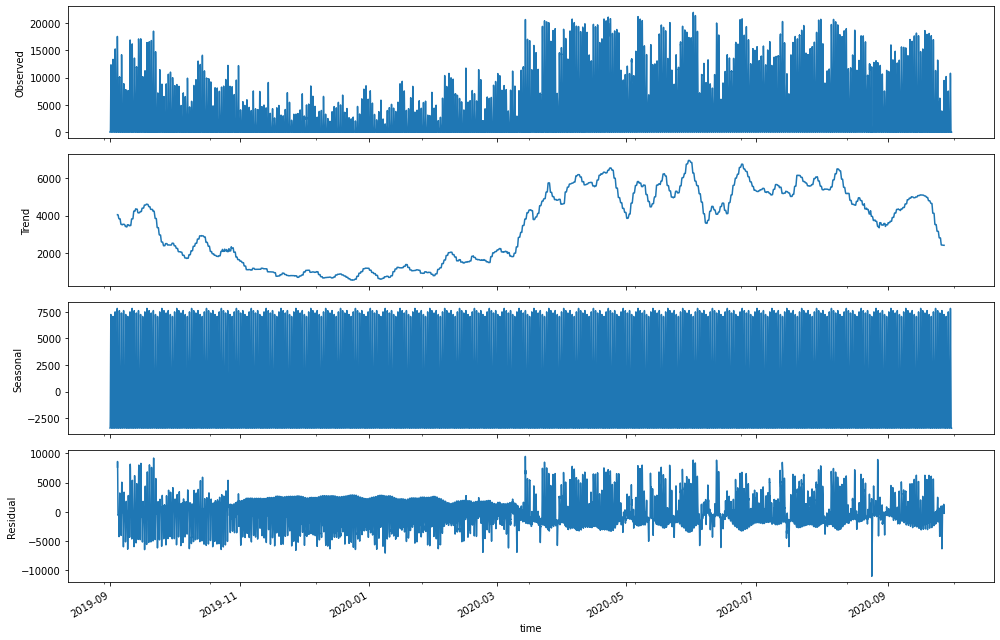

In [21]:
decompfreq = int(((24*60)/15)*7)
res = sm.tsa.seasonal_decompose(aggregate_pv_df.Hochrechnung_Total.interpolate(),
                               freq=decompfreq,model='additive')
pylab.rcParams['figure.figsize'] = (14, 9)
resplot = res.plot()

# Phasor angle data

### Data Pre-processing

In [22]:
path2 = '/content/drive/My Drive/5/phase-angle-1s_2019-09-01_2020-09-30.csv'

In [23]:
# Peep at the training file header
df_tmp = pd.read_csv(path2, nrows=901, parse_dates =['time'], keep_date_col = True)
df_tmp

time  Winterthur  Büdingen  ...  Sibiu  Belfort Cedex  Wien (SBA)
0   2019-09-01 00:00:00         NaN       305  ...    164            177         NaN
1   2019-09-01 00:00:01         NaN       303  ...    163            176         NaN
2   2019-09-01 00:00:02         NaN       301  ...    161            174         NaN
3   2019-09-01 00:00:03         NaN       299  ...    158            171         NaN
4   2019-09-01 00:00:04         NaN       295  ...    155            168         NaN
..                  ...         ...       ...  ...    ...            ...         ...
896 2019-09-01 00:14:56         NaN       253  ...    123            128         NaN
897 2019-09-01 00:14:57         NaN       251  ...    121            126         NaN
898 2019-09-01 00:14:58         NaN       249  ...    119            124         NaN
899 2019-09-01 00:14:59         NaN       248  ...    118            122         NaN
900 2019-09-01 00:15:00         NaN       246  ...    116            121         NaN

[901 rows x 11 columns]

In [24]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           901 non-null    datetime64[ns]
 1   Winterthur     0 non-null      float64       
 2   Büdingen       901 non-null    int64         
 3   Schondorf      901 non-null    int64         
 4   Herzogenrath   901 non-null    int64         
 5   Bremen         0 non-null      float64       
 6   Dresden        901 non-null    int64         
 7   Lleida         901 non-null    int64         
 8   Sibiu          901 non-null    int64         
 9   Belfort Cedex  901 non-null    int64         
 10  Wien (SBA)     0 non-null      float64       
dtypes: datetime64[ns](1), float64(3), int64(7)
memory usage: 77.6 KB


In [25]:
missing_val = (df_tmp.isna().sum())
print(missing_val)

time               0
Winterthur       901
Büdingen           0
Schondorf          0
Herzogenrath       0
Bremen           901
Dresden            0
Lleida             0
Sibiu              0
Belfort Cedex      0
Wien (SBA)       901
dtype: int64


In [26]:
#Let's take locations Herzogenrath and Schondorf for demonstration purpose
df_tmp = df_tmp.set_index(['time'])  

df_tmp['phase_diff'] = df_tmp['Herzogenrath'] - df_tmp['Schondorf']
df_tmp['angle'] = np.sin(np.deg2rad(df_tmp['phase_diff']))

### Visualizing 15 min interval of the time series

In [27]:
%matplotlib inline
fig = px.line(x=df_tmp.index, y=df_tmp['Herzogenrath'], title='site1 \n in degrees')
fig.update_xaxes()
fig.show()

In [28]:
%matplotlib inline
fig = px.line(x=df_tmp.index, y=df_tmp['phase_diff'], title='site1 - site2 \n  in degrees')
fig.update_xaxes()
fig.show()

In [29]:
%matplotlib inline
fig = px.line(x=df_tmp.index, y=df_tmp['angle'], title='sin (site1 - site2 \n)')
fig.update_xaxes()
fig.show()

In [30]:
#Locations
site1 = "Winterthur"
site2 = "Büdingen"
site3 = "Schondorf"
site4 = "Herzogenrath"
site5 = "Bremen"
site6=  "Dresden"
site7 = "Lleida"
site8 = "Sibiu"
site9 = "Belfort Cedex"
site10 = "Wien (SBA)"

In [31]:
chunksize = 10000000

In [32]:
%%time
df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(path2, usecols=("time",site1, site2,site3,site4,site5,site6,site7,site8,site9,site10),parse_dates =['time'], keep_date_col = True, chunksize=chunksize)):
     
    df_chunk = df_chunk.set_index(['time'])
    #df_chunk['time'] = pd.to_datetime(df_chunk['time'], utc=True, format='%Y-%m-%d %H:%M:%S')
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk)
    

# Merge all dataframes into one dataframe
data = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
data.info()

4it [01:06, 16.54s/it]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34214399 entries, 2019-09-01 00:00:00 to 2020-09-30 23:59:58
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Winterthur     float64
 1   Büdingen       float64
 2   Schondorf      float64
 3   Herzogenrath   float64
 4   Bremen         float64
 5   Dresden        float64
 6   Lleida         float64
 7   Sibiu          float64
 8   Belfort Cedex  float64
 9   Wien (SBA)     float64
dtypes: float64(10)
memory usage: 2.8 GB
CPU times: user 47.4 s, sys: 16.9 s, total: 1min 4s
Wall time: 1min 10s


In [33]:
data.head()

Winterthur  Büdingen  ...  Belfort Cedex  Wien (SBA)
time                                       ...                           
2019-09-01 00:00:00         NaN     305.0  ...          177.0         NaN
2019-09-01 00:00:01         NaN     303.0  ...          176.0         NaN
2019-09-01 00:00:02         NaN     301.0  ...          174.0         NaN
2019-09-01 00:00:03         NaN     299.0  ...          171.0         NaN
2019-09-01 00:00:04         NaN     295.0  ...          168.0         NaN

[5 rows x 10 columns]

In [34]:
data.tail()

Winterthur  Büdingen  ...  Belfort Cedex  Wien (SBA)
time                                       ...                           
2020-09-30 23:59:54       358.0     252.0  ...          105.0       209.0
2020-09-30 23:59:55       348.0     241.0  ...           94.0       199.0
2020-09-30 23:59:56       337.0     231.0  ...           84.0       189.0
2020-09-30 23:59:57       326.0     220.0  ...           73.0       178.0
2020-09-30 23:59:58       315.0     209.0  ...           61.0       167.0

[5 rows x 10 columns]

In [35]:
data.shape

(34214399, 10)

In [36]:
# start and end dates of the time series
print ("phase angle dataset: start_date = {}, end_date = {} \n".format(data.index.min(), data.index.max()))

phase angle dataset: start_date = 2019-09-01 00:00:00, end_date = 2020-09-30 23:59:58 



In [37]:
missing_val = (data.isna().sum())
print(missing_val)

Winterthur       18118947
Büdingen             6965
Schondorf          108469
Herzogenrath       382998
Bremen           11015690
Dresden             81291
Lleida              51146
Sibiu               17952
Belfort Cedex      243215
Wien (SBA)        5852146
dtype: int64


In [38]:
%%time
df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(path2, usecols=("time",site1, site2,site3,site4,site5,site6,site7,site8,site9,site10),parse_dates =['time'], keep_date_col = True, chunksize=chunksize)):
    #We will resample the data to 15 min to be able to plot; dataset is too large and require additional memory to process

    df_chunk = df_chunk.set_index(['time'])
    df_chunk = df_chunk.resample('15 min').mean()
    
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk)
    

# Merge all dataframes into one dataframe
data_df = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
data_df.info()

4it [00:50, 12.51s/it]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38019 entries, 2019-09-01 00:00:00 to 2020-09-30 23:45:00
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Winterthur     17915 non-null  float64
 1   Büdingen       38016 non-null  float64
 2   Schondorf      37906 non-null  float64
 3   Herzogenrath   37602 non-null  float64
 4   Bremen         25780 non-null  float64
 5   Dresden        37940 non-null  float64
 6   Lleida         38011 non-null  float64
 7   Sibiu          38006 non-null  float64
 8   Belfort Cedex  37756 non-null  float64
 9   Wien (SBA)     31518 non-null  float64
dtypes: float64(10)
memory usage: 3.2 MB
CPU times: user 44.1 s, sys: 3.76 s, total: 47.9 s
Wall time: 50.2 s


In [39]:
data_df.shape

(38019, 10)

In [40]:
missing_val = (data_df.isna().sum())
print(missing_val)

Winterthur       20104
Büdingen             3
Schondorf          113
Herzogenrath       417
Bremen           12239
Dresden             79
Lleida               8
Sibiu               13
Belfort Cedex      263
Wien (SBA)        6501
dtype: int64


CPU times: user 1.76 s, sys: 111 ms, total: 1.87 s
Wall time: 1.76 s


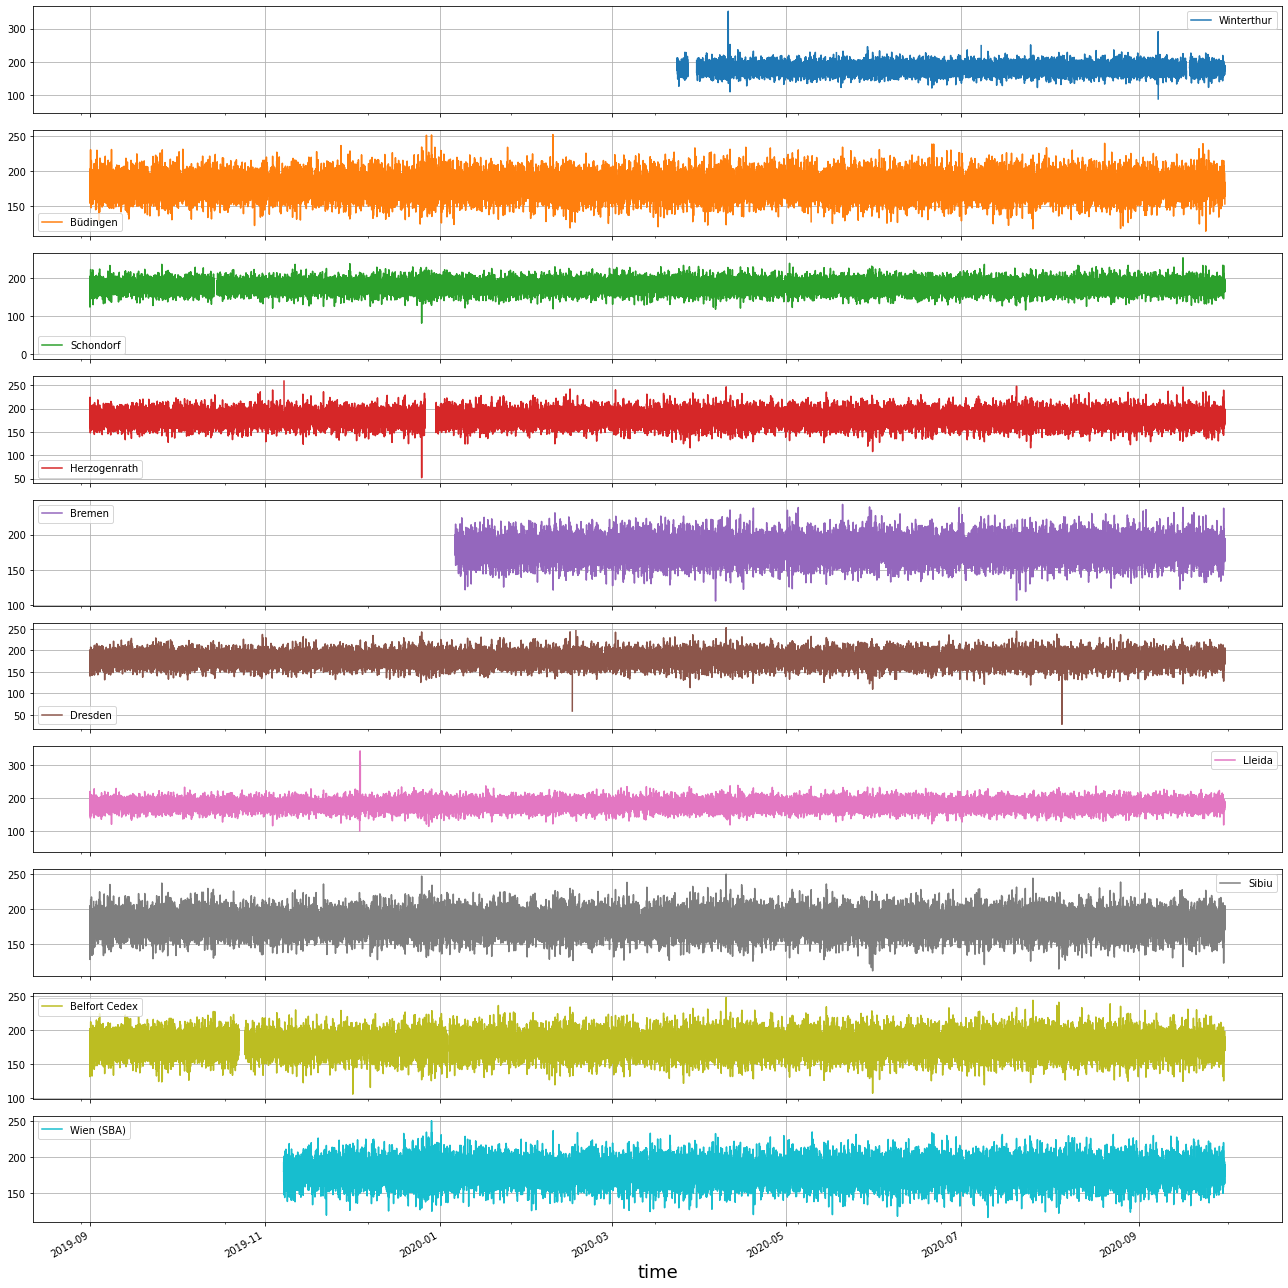

In [41]:
%%time
data_df.plot(grid=True, subplots=True, figsize=(18,18))
plt.xlabel('time', fontsize=18)
plt.legend(loc='upper left')
plt.tight_layout()

#### Let's choose regions in Germany located in opposite geographical directions that to say Bremen(North), Herzogenrath(North), Büdingen(South-East) and Schondorf(South) for the project.
#### Notice that Bremen appears to miss data from misses from September 2019 to January 2020.

In [42]:
#Locations chosen for the project
site2 = "Büdingen"
site3 = "Schondorf"
site4 = "Herzogenrath"
site5 = "Bremen"

In [43]:
%%time
df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(path2, usecols=("time",site2,site3,site4,site5),parse_dates =['time'], keep_date_col = True, chunksize=chunksize)):
    #We will resample the data to 15 min to be able to plot; dataset is too large and require additional memory to process

    df_chunk = df_chunk.set_index(['time'])
    df_chunk = df_chunk.resample('15 min').mean()
    
    # Append the chunk to list and merge all
    df_list.append(df_chunk)
    

# Merge all dataframes into one dataframe
df_data = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
df_data.info()

4it [00:42, 10.71s/it]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38019 entries, 2019-09-01 00:00:00 to 2020-09-30 23:45:00
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Büdingen      38016 non-null  float64
 1   Schondorf     37906 non-null  float64
 2   Herzogenrath  37602 non-null  float64
 3   Bremen        25780 non-null  float64
dtypes: float64(4)
memory usage: 1.5 MB
CPU times: user 37.9 s, sys: 2.91 s, total: 40.8 s
Wall time: 43 s


In [44]:
df_data.shape

(38019, 4)

In [45]:
# start and end dates of the time series
print ("phase angle dataset: start_date = {}, end_date = {} \n".format(df_data.index.min(), df_data.index.max()))

phase angle dataset: start_date = 2019-09-01 00:00:00, end_date = 2020-09-30 23:45:00 



In [46]:
missing_val = (df_data.isna().sum())
print(missing_val)

Büdingen            3
Schondorf         113
Herzogenrath      417
Bremen          12239
dtype: int64


CPU times: user 603 ms, sys: 107 ms, total: 710 ms
Wall time: 603 ms


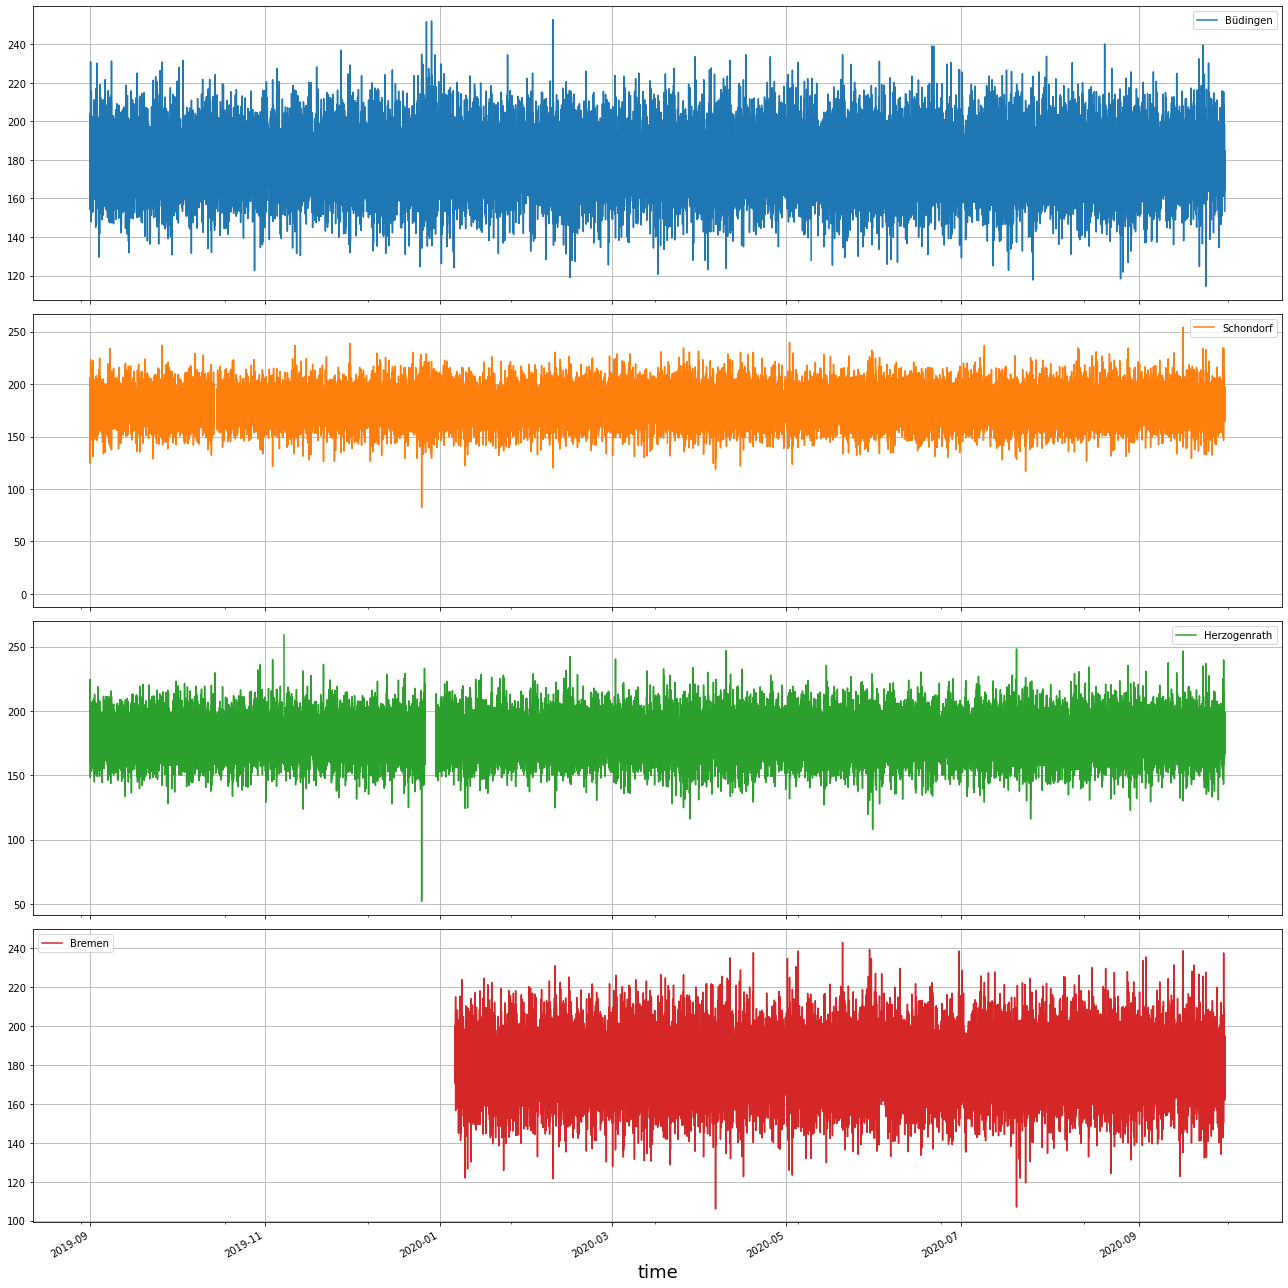

In [47]:
%%time
df_data.plot(grid=True, subplots=True, figsize=(18,18))
plt.xlabel('time', fontsize=18)
plt.legend(loc='upper left')
plt.tight_layout()

#### Bremen data starts around the beginning of January

In [48]:
%%time
df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(path2, usecols=("time",site2,site3,site4,site5),parse_dates =['time'], keep_date_col = True, chunksize=chunksize)):
    
    df_chunk = df_chunk.set_index(['time'])  
    # Can process each chunk of dataframe here
    # clean_data(), pre_process_data()
    
    #df_chunk = df_chunk.assign(Büdingen2=df_chunk.Büdingen.fillna(df_chunk.Büdingen.mean()))
    df_chunk = df_chunk.assign(Herzogenrath2=df_chunk.Herzogenrath.fillna(df_chunk.Herzogenrath.mean()))
    df_chunk = df_chunk.assign(Schondorf2=df_chunk.Schondorf.fillna(df_chunk.Schondorf.mean()))
   
    df_chunk['phase_diff1'] = (df_chunk['Bremen'] - df_chunk['Schondorf2'])
    df_chunk['angle1'] = np.sin(np.deg2rad(df_chunk['phase_diff1']))
    
    
    df_chunk['phase_diff2'] = (df_chunk['Herzogenrath2'] - df_chunk['Schondorf2'])
    df_chunk['angle2'] = np.sin(np.deg2rad(df_chunk['phase_diff2']))
    
    df_chunk['phase_diff3'] = (df_chunk['Bremen'] - df_chunk['Büdingen'])
    df_chunk['angle3'] = np.sin(np.deg2rad(df_chunk['phase_diff3']))
    
    #df_chunk['time'] = pd.to_datetime(df_chunk['time'], format='%Y-%m-%d %H:%M:%S')
    df_chunk = df_chunk.resample('15 min').mean()
    #df2_chunk = df2_chunk.set_index(['time'])

    
    # Append the chunk to list and merge all
    df_list.append(df_chunk)

# Merge all dataframes into one dataframe
phasor_data = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what I have loaded
phasor_data.info()

4it [00:51, 12.75s/it]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38019 entries, 2019-09-01 00:00:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Büdingen       38016 non-null  float64
 1   Schondorf      37906 non-null  float64
 2   Herzogenrath   37602 non-null  float64
 3   Bremen         25780 non-null  float64
 4   Herzogenrath2  38019 non-null  float64
 5   Schondorf2     38019 non-null  float64
 6   phase_diff1    25780 non-null  float64
 7   angle1         25780 non-null  float64
 8   phase_diff2    38019 non-null  float64
 9   angle2         38019 non-null  float64
 10  phase_diff3    25778 non-null  float64
 11  angle3         25778 non-null  float64
dtypes: float64(12)
memory usage: 3.8 MB
CPU times: user 44 s, sys: 4.8 s, total: 48.8 s
Wall time: 51.2 s


In [49]:
phasor_data.shape

(38019, 12)

In [50]:
# start and end dates of the time series
print ("phase angle dataset: start_date = {}, end_date = {} \n".format(phasor_data.index.min(), phasor_data.index.max()))

phase angle dataset: start_date = 2019-09-01 00:00:00, end_date = 2020-09-30 23:45:00 



In [51]:
missing_val = (phasor_data.isna().sum())
print(missing_val)

Büdingen             3
Schondorf          113
Herzogenrath       417
Bremen           12239
Herzogenrath2        0
Schondorf2           0
phase_diff1      12239
angle1           12239
phase_diff2          0
angle2               0
phase_diff3      12241
angle3           12241
dtype: int64


In [52]:
phasor_data.head()

Büdingen   Schondorf  ...  phase_diff3  angle3
time                                         ...                     
2019-09-01 00:00:00  191.358889  179.578889  ...          NaN     NaN
2019-09-01 00:15:00  172.280000  156.652222  ...          NaN     NaN
2019-09-01 00:30:00  199.106667  124.571111  ...          NaN     NaN
2019-09-01 00:45:00  184.902222  180.196667  ...          NaN     NaN
2019-09-01 01:00:00  191.037778  167.571111  ...          NaN     NaN

[5 rows x 12 columns]

In [53]:
phasor_data.describe()

Büdingen     Schondorf  ...   phase_diff3        angle3
count  38016.000000  37906.000000  ...  25778.000000  25778.000000
mean     179.323555    179.362588  ...     -0.001093      0.737976
std       13.211960     13.200885  ...     13.813466      0.200292
min      114.414444      0.000000  ...    -91.666296     -0.995893
25%      171.473056    171.648333  ...     -6.748611      0.608533
50%      179.363889    179.390556  ...      1.214444      0.765899
75%      187.048889    187.062222  ...      8.085278      0.896674
max      252.744444    254.212222  ...     84.054444      0.998964

[8 rows x 12 columns]

CPU times: user 1.81 s, sys: 117 ms, total: 1.93 s
Wall time: 1.84 s


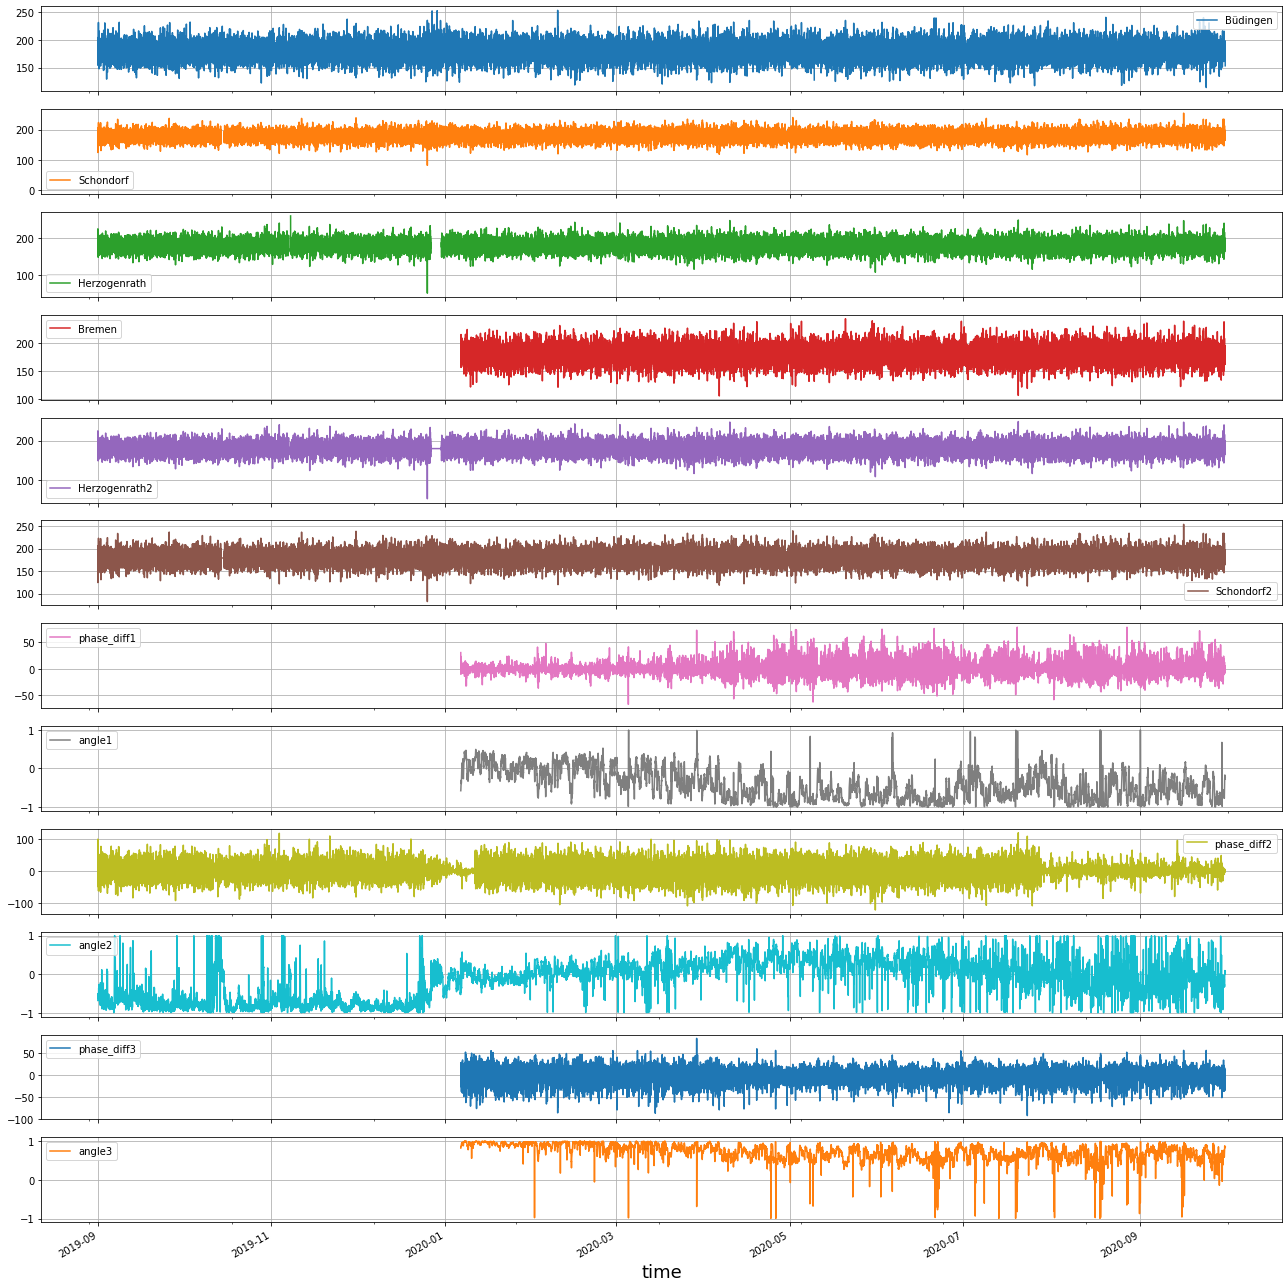

In [54]:
%%time
phasor_data.plot(grid=True, subplots=True, figsize=(18,18))
plt.xlabel('time', fontsize=18)
plt.legend(loc='upper left')
plt.tight_layout()

## Let's use the time series from Jan 2020, since Bremen misses data from September 2019 until Jan 7th, 2020

In [55]:
angle_data = phasor_data[['angle1', 'angle2', 'angle3']].copy()
#angle_data.head()

phasor = angle_data.copy()
phasor = phasor.reset_index()
time_df = (phasor['time'] >= ('2020-01-07 00:00:00')) & (phasor['time'] <= ('2020-09-30 23:45:00'))
phasor_df = phasor.loc[time_df]
phasor_df = phasor_df.set_index(['time'])

print("angle1 : Bremen_Schondorf")
print("angle2: Herzogenrath_Schondorf")
print("angle3: Bremen_Büdingen")

phasor_df.head()

angle1 : Bremen_Schondorf
angle2: Herzogenrath_Schondorf
angle3: Bremen_Büdingen


angle1    angle2    angle3
time                                             
2020-01-07 00:00:00  0.101091  0.054101  0.956162
2020-01-07 00:15:00  0.092844  0.040110  0.953309
2020-01-07 00:30:00  0.099271  0.043656  0.953645
2020-01-07 00:45:00  0.095014  0.042996  0.952869
2020-01-07 01:00:00  0.120647  0.059410  0.955343

In [56]:
phasor_df.isna().sum()

angle1    0
angle2    0
angle3    2
dtype: int64

## Visualization of power flow transfer between 2 locations

In [57]:
%matplotlib inline
fig1 = px.line(x=phasor_df.index, y=phasor_df['angle2'], title='Power flow transfer between Herzogenrath & Schondorf')
#fig1.update_xaxes(rangeslider_visible=False)
fig1.show()

In [58]:
#%matplotlib inline

fig2 = px.line(x=phasor_df.index, y=phasor_df['angle1'], title='Power flow transfer between Bremen & Schondorf')
fig2.update_xaxes(rangeslider_visible=False)
fig2.show()


In [59]:
%matplotlib inline
fig3 = px.line(x=phasor_df.index, y=phasor_df['angle3'], title='Power flow transfer between Bremen & Büdingen')
fig3.update_xaxes(rangeslider_visible=False)
fig3.show()

In [60]:
# start and end dates of the time series
print ("phase angle dataset: start_date = {}, end_date = {} \n".format(phasor_df.index.min(), phasor_df.index.max()))

phase angle dataset: start_date = 2020-01-07 00:00:00, end_date = 2020-09-30 23:45:00 



## Heatmap visualization between 2 locations

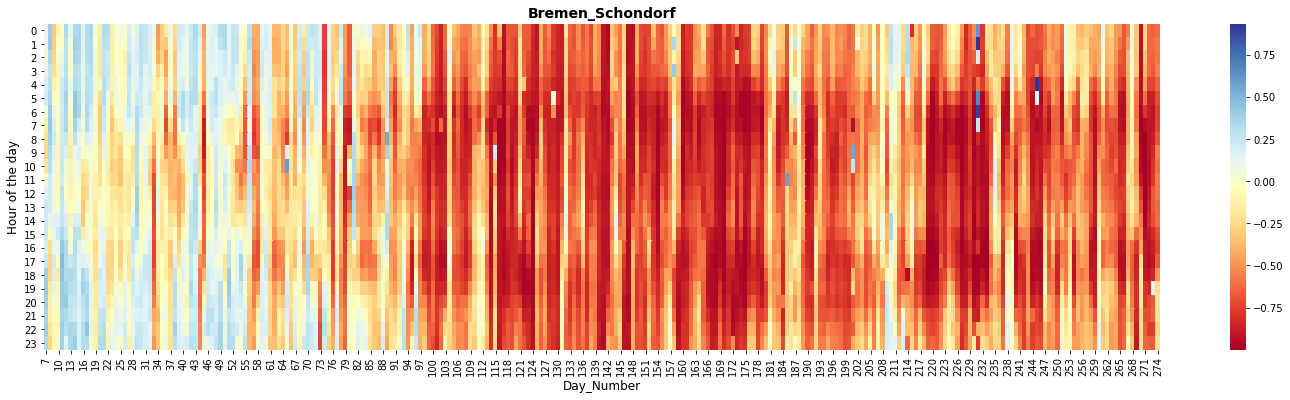

In [61]:
heatmap_df1 = phasor_df.copy()

#Create variables for Day and hour
heatmap_df1['Day'] = [i.dayofyear for i in heatmap_df1.index]
heatmap_df1['hour'] = [i.hour for i in heatmap_df1.index]

#Group by day and hour and aggregate
heatmap_df1 = heatmap_df1.groupby(['Day','hour']).mean()

#Use unstack function to prepare the data to be plotted
heatmap_df1= heatmap_df1['angle1'].unstack(level=0)

fig1, ax = plt.subplots(figsize=(25, 6))

fig1.canvas.draw()
cmap = 'RdYlBu'


sns.heatmap(heatmap_df1, cmap=cmap)

#plt.title('Herzogenrath_Schondorf \n (Jan 2020 - Sept 2020)', fontweight='bold', fontsize = 14)
plt.title('Bremen_Schondorf', fontweight='bold', fontsize = 14)
plt.xlabel("Day_Number", fontsize=12)
plt.ylabel("Hour of the day", fontsize=12)

plt.yticks(rotation=0)
#plt.xticks('Day -' + from_jan_2020.Day)

labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[2] = 'Day -'

ax.set_xticklabels(labels)
plt.show()

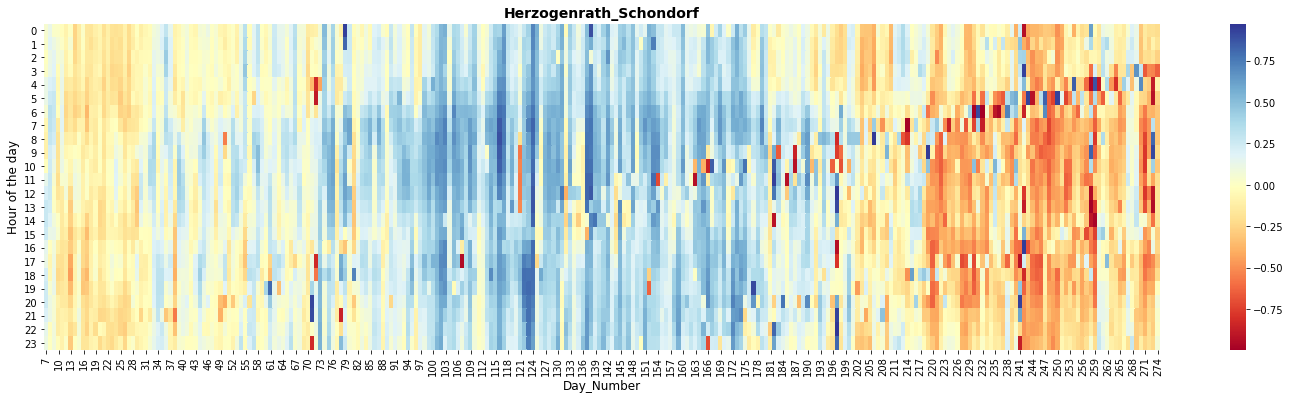

In [62]:
heatmap_df2 = phasor_df.copy()

#Create variables for Day and hour
heatmap_df2['day'] = [i.dayofyear for i in heatmap_df2.index]
heatmap_df2['hour'] = [i.hour for i in heatmap_df2.index]

#Group by day and hour and aggregate
heatmap_df2 = heatmap_df2.groupby(['day','hour']).mean()

#Use unstack function to prepare the data to be plotted
heatmap_df2= heatmap_df2['angle2'].unstack(level=0)


fig2, ax = plt.subplots(figsize=(25, 6))

fig2.canvas.draw()
cmap = 'RdYlBu'


sns.heatmap(heatmap_df2, cmap=cmap)

#plt.title('Herzogenrath_Schondorf \n (Jan 2020 - Sept 2020)', fontweight='bold', fontsize = 14)
plt.title('Herzogenrath_Schondorf', fontweight='bold', fontsize = 14)
plt.xlabel("Day_Number", fontsize=12)
plt.ylabel("Hour of the day", fontsize=12)

plt.yticks(rotation=0)
#plt.xticks('Day -' + from_jan_2020.Day)

labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[2] = 'Day -'

ax.set_xticklabels(labels)
plt.show()

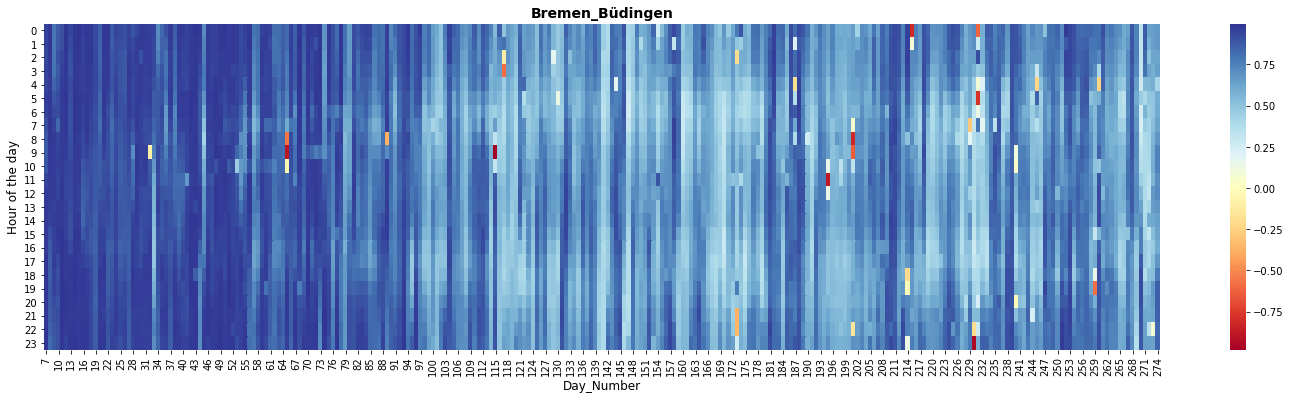

In [63]:
heatmap_df3 = phasor_df.copy()

#Create variables for Day and hour
heatmap_df3['Day'] = [i.dayofyear for i in heatmap_df3.index]
heatmap_df3['hour'] = [i.hour for i in heatmap_df3.index]

#Group by day and hour and aggregate
heatmap_df3 = heatmap_df3.groupby(['Day','hour']).mean()


#Use unstack function to prepare the data to be plotted
heatmap_df3= heatmap_df3['angle3'].unstack(level=0)


fig3, ax = plt.subplots(figsize=(25, 6))

fig3.canvas.draw()
#cmap = 'YlGnBu'
#cmap = 'YlGnBu'
#cmap = 'YlOrBr'
#cmap = 'BuGn_r'
cmap = 'RdYlBu'


sns.heatmap(heatmap_df3, cmap=cmap)

#plt.title('Herzogenrath_Schondorf \n (Jan 2020 - Sept 2020)', fontweight='bold', fontsize = 14)
plt.title('Bremen_Büdingen', fontweight='bold', fontsize = 14)
plt.xlabel("Day_Number", fontsize=12)
plt.ylabel("Hour of the day", fontsize=12)

plt.yticks(rotation=0)
#plt.xticks('Day -' + from_jan_2020.Day)

labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[2] = 'Day -'

ax.set_xticklabels(labels)
plt.show()

Frequency Time Series Decomposition

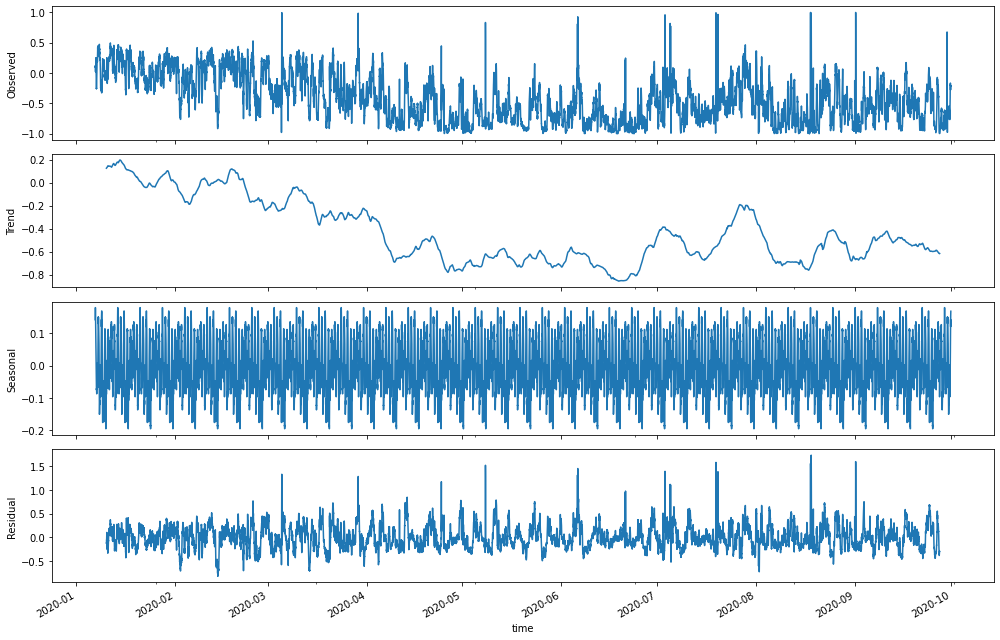

In [64]:
decompfreq = int(((24*60)/15)*7)
res = sm.tsa.seasonal_decompose(phasor_df.angle1.interpolate(),
                               freq=decompfreq,model='additive')
pylab.rcParams['figure.figsize'] = (14, 9)
resplot = res.plot()

## Correlation between solar energy and phasor angle

#### Let's choose time series from Jan 2020 for solar energy as we did for phasor angle data

In [65]:
aggregate_pv_df.head()

Hochrechnung_Total  Prognose_Total
time                                                   
2019-09-01 00:00:00               19.29             0.0
2019-09-01 00:15:00               19.26             0.0
2019-09-01 00:30:00               19.26             0.0
2019-09-01 00:45:00               19.24             0.0
2019-09-01 01:00:00               19.25             0.0

In [66]:
energy = aggregate_pv_df.copy()
energy = energy.reset_index()
time_series = (energy['time'] >= ('2020-01-07 00:00:00')) & (energy['time'] <= ('2020-09-30 23:45:00'))
pv_df = energy.loc[time_series]
pv_df = pv_df.set_index(['time'])
pv_df.head()

Hochrechnung_Total  Prognose_Total
time                                                   
2020-01-07 00:00:00                 0.0             0.0
2020-01-07 00:15:00                 0.0             0.0
2020-01-07 00:30:00                 0.0             0.0
2020-01-07 00:45:00                 0.0             0.0
2020-01-07 01:00:00                 0.0             0.0

In [67]:
pv_df.isna().sum()

Hochrechnung_Total    0
Prognose_Total        0
dtype: int64

In [68]:
# start and end dates of the time series
print ("PV dataset: start_date = {}, end_date = {} \n".format(pv_df.index.min(), pv_df.index.max()))

PV dataset: start_date = 2020-01-07 00:00:00, end_date = 2020-09-30 23:45:00 



In [69]:
data1 = phasor_df.copy()
data2 = pv_df.copy()
data1 = data1.reset_index()
data2 = data2.reset_index()

all_data = data1.merge(data2, left_on=['time'], right_on=['time'], how='right')


#data = data.drop(['Winterthur', 'Dresden','Lleida','Sibiu','Belfort Cedex','Wien (SBA)'], axis = 1)
df = all_data.copy()
df.rename(columns = {'angle1':'phasor_diff1','angle2':'phasor_diff2','angle3':'phasor_diff3',
                   'Hochrechnung_Total':'PV_hoch', 'Prognose_Total':'PV_prog'}, inplace = True)
#df.rename(columns = {'angle1':'phasor_diff1','angle2':'phasor_diff2',
                   #'Hochrechnung_Total':'Solar_energy',
                   #'Prognose_Total':'Prognose'}, inplace = True)
#df.head()
print("phasor_diff1 : Bremen_Schondorf")
print("phasor_diff2: Herzogenrath_Schondorf")
print("phasor_diff3: Bremen_Büdingen")

corr = df.corr().loc[['phasor_diff1', 'phasor_diff2', 'phasor_diff3','PV_hoch', 'PV_prog'], ['phasor_diff1', 'phasor_diff2','phasor_diff3', 'PV_hoch', 'PV_prog']]
display(corr)

#corr = df.corr().loc[['phasor_angle1', 'energy_hoch'], ['phasor_angle1', 'energy_hoch']]
#display(corr)

#fig = plt.subplots(figsize=(7, 4))
#cmap = 'Reds'
#cmap = 'YlGnBu'
#cmap = 'YlOrBr'
#cmap = 'BuGn_r'
#cmap = 'RdYlBu'
#cmap = 'GnBu'
#cmap="OrRd"
#sns.heatmap(corr, cmap=cmap)

#plt.show()


phasor_diff1 : Bremen_Schondorf
phasor_diff2: Herzogenrath_Schondorf
phasor_diff3: Bremen_Büdingen


phasor_diff1  phasor_diff2  phasor_diff3   PV_hoch   PV_prog
phasor_diff1      1.000000     -0.230531      0.753927 -0.311195 -0.310252
phasor_diff2     -0.230531      1.000000     -0.136792  0.129097  0.124821
phasor_diff3      0.753927     -0.136792      1.000000 -0.177119 -0.176065
PV_hoch          -0.311195      0.129097     -0.177119  1.000000  0.993790
PV_prog          -0.310252      0.124821     -0.176065  0.993790  1.000000

In [70]:
df.shape

(25730, 6)

In [71]:
df.head()

time  phasor_diff1  ...  PV_hoch  PV_prog
0 2020-01-07 00:00:00      0.101091  ...      0.0      0.0
1 2020-01-07 00:15:00      0.092844  ...      0.0      0.0
2 2020-01-07 00:30:00      0.099271  ...      0.0      0.0
3 2020-01-07 00:45:00      0.095014  ...      0.0      0.0
4 2020-01-07 01:00:00      0.120647  ...      0.0      0.0

[5 rows x 6 columns]

# Forecast

### Looking at solar energy and phasor angle, can you forecast phase angle

In [72]:
new_df2 = df[['time', 'phasor_diff1', 'PV_hoch']].copy()
new_df2 = new_df2.set_index(['time'])
new_df2.head()

phasor_diff1  PV_hoch
time                                      
2020-01-07 00:00:00      0.101091      0.0
2020-01-07 00:15:00      0.092844      0.0
2020-01-07 00:30:00      0.099271      0.0
2020-01-07 00:45:00      0.095014      0.0
2020-01-07 01:00:00      0.120647      0.0

In [73]:
# start and end dates of the time series
print ("Dataset: start_date = {}, end_date = {} \n".format(new_df2.index.min(), new_df2.index.max()))

Dataset: start_date = 2020-01-07 00:00:00, end_date = 2020-09-30 23:45:00 



In [74]:
new_df2.describe()

phasor_diff1       PV_hoch
count  25730.000000  25730.000000
mean      -0.428652   4190.637431
std        0.378404   5741.733984
min       -0.999904      0.000000
25%       -0.750395      0.000000
50%       -0.484100    497.229500
75%       -0.141554   7587.584500
max        0.995455  21944.654000

In [75]:
#the supervised learning algorithm was adopted from
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [76]:
## Scale all features in range of [0,1].
values = new_df2.values 

#features normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 18)
#print(reframed.head())
# columns we don't need to predict are dropped
#reframed.drop(reframed.columns[[3,5,7,9]], axis=1, inplace=True)
reframed.drop(reframed.columns[[3,5,7,9,11,13,15,17,19,21,23,25,27,29,30,31,33,35,37]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)   var1(t)  ...  var1(t+15)  var1(t+16)  var1(t+17)
1   0.551778        0.0  0.547645  ...    0.586500    0.591639    0.592182
2   0.547645        0.0  0.550866  ...    0.591639    0.592182    0.606538
3   0.550866        0.0  0.548732  ...    0.592182    0.606538    0.626374
4   0.548732        0.0  0.561579  ...    0.606538    0.626374    0.606854
5   0.561579        0.0  0.562562  ...    0.626374    0.606854    0.586919

[5 rows x 19 columns]


In [77]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25712 entries, 1 to 25712
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   var1(t-1)   25712 non-null  float64
 1   var2(t-1)   25712 non-null  float64
 2   var1(t)     25712 non-null  float64
 3   var1(t+1)   25712 non-null  float64
 4   var1(t+2)   25712 non-null  float64
 5   var1(t+3)   25712 non-null  float64
 6   var1(t+4)   25712 non-null  float64
 7   var1(t+5)   25712 non-null  float64
 8   var1(t+6)   25712 non-null  float64
 9   var1(t+7)   25712 non-null  float64
 10  var1(t+8)   25712 non-null  float64
 11  var1(t+9)   25712 non-null  float64
 12  var1(t+10)  25712 non-null  float64
 13  var1(t+11)  25712 non-null  float64
 14  var1(t+12)  25712 non-null  float64
 15  var1(t+13)  25712 non-null  float64
 16  var1(t+15)  25712 non-null  float64
 17  var1(t+16)  25712 non-null  float64
 18  var1(t+17)  25712 non-null  float64
dtypes: float64(19)
memory usa

In [78]:
reframed.describe()

var1(t-1)     var2(t-1)  ...    var1(t+16)    var1(t+17)
count  25712.000000  25712.000000  ...  25712.000000  25712.000000
mean       0.286217      0.191098  ...      0.286116      0.286108
std        0.189688      0.261689  ...      0.189591      0.189582
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.124969      0.000000  ...      0.124969      0.124969
50%        0.258174      0.022938  ...      0.258174      0.258174
75%        0.430368      0.346052  ...      0.429826      0.429801
max        1.000000      1.000000  ...      1.000000      1.000000

[8 rows x 19 columns]

In [79]:
# split into train and test sets
values = reframed.values

train_size = int(len(values) * 0.67)
test_size = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:len(scaled),:]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# The input is reshaped into a 3D format as expected by LSTMs, namely [samples, timesteps, features].

(17227, 1, 18) (17227,) (8485, 1, 18) (8485,)


Epoch 1/20
247/247 [==============================] - 5s 10ms/step - loss: 0.0803 - val_loss: 0.0040
Epoch 2/20
247/247 [==============================] - 2s 7ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 3/20
247/247 [==============================] - 2s 7ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 4/20
247/247 [==============================] - 2s 7ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 5/20
247/247 [==============================] - 2s 7ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 6/20
247/247 [==============================] - 2s 7ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 7/20
247/247 [==============================] - 2s 8ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 8/20
247/247 [==============================] - 2s 7ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 9/20
247/247 [==============================] - 2s 7ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 10/20
247/247 [==============================] - 2s 7ms/step - loss: 0.0025 - val_loss: 0.001

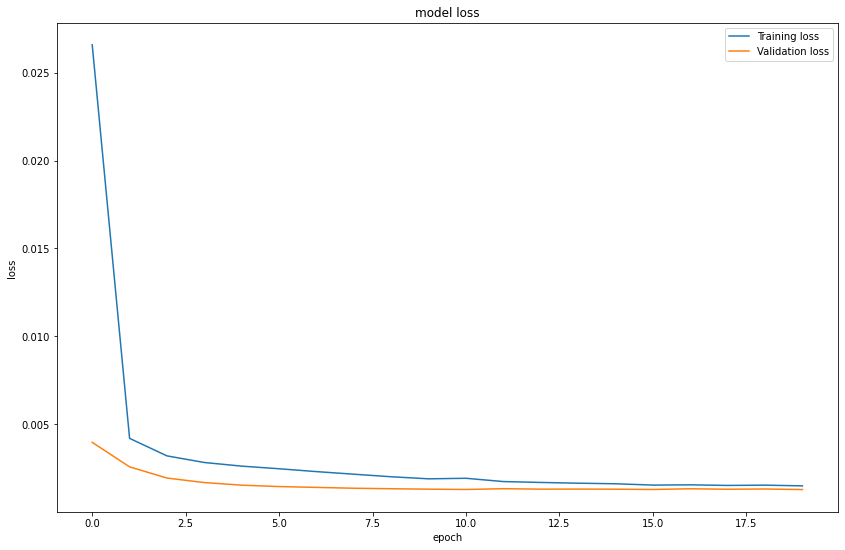

Train RMSE: 0.052
Train MAE: 0.029
Test RMSE: 0.071
Test MAE: 0.032


In [80]:
model = Sequential()
model.add(LSTM(128, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu',return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
#model.summary()

# fit model
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=1, shuffle=False)


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')

plt.show()

# make a prediction
vhat = model.predict(train_X) ## train
yhat = model.predict(test_X) ## test
test_X = test_X.reshape((test_X.shape[0], 18))
train_X = train_X.reshape((train_X.shape[0], 18))

# invert scaling for forecast (train)
inv_vhat = np.concatenate((vhat, train_X[:, -1:]), axis=1)
inv_vhat = scaler.inverse_transform(inv_vhat)
inv_vhat = inv_vhat[:,0]

# invert scaling for forecast (test)
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual (train)
train_y = train_y.reshape((len(train_y), 1))
inv2_y = np.concatenate((train_y, train_X[:, -1:]), axis=1)
inv2_y = scaler.inverse_transform(inv2_y)
inv2_y = inv2_y[:,0]

# invert scaling for actual (test)
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


# calculate RMSE and MAE train and test
rmse2 = np.sqrt(mean_squared_error(inv2_y, inv_vhat))
print('Train RMSE: %.3f' % rmse2)
mae2 = mean_absolute_error(inv2_y, inv_vhat)
print('Train MAE: %.3f' % mae2)

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

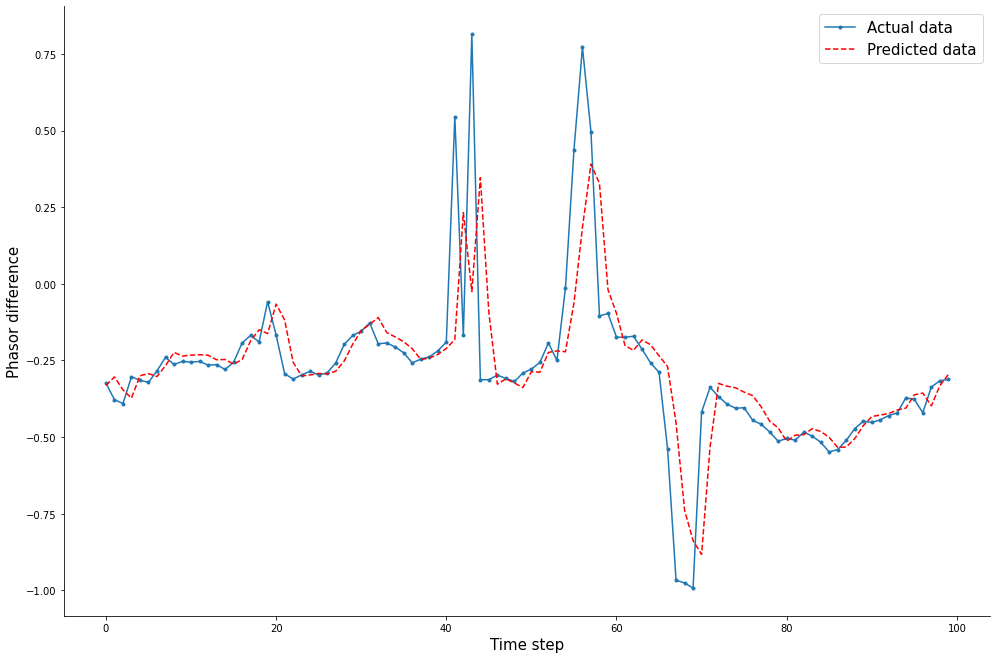

In [81]:
## time steps, every step is 15 min (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in few steps. 

aa=[x for x in range(100)]

plt.plot(aa,inv_y[:100], marker='.', label="Actual data")
plt.plot(aa,inv_yhat[:100], '--r', label="Predicted data")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Phasor difference', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()